**Naive bayes classifier**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/AI and algorithms lab/Breast_cancer_data.csv")
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


<Axes: >

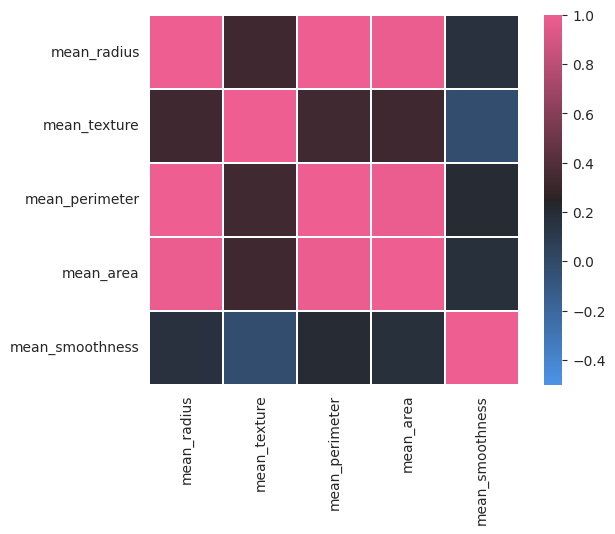

In [4]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [5]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


In [6]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

In [7]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

In [8]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


**Bayesian belief network**

In [15]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
import bnlearn

In [24]:
from pgmpy.factors.discrete import TabularCPD
rain_model = BayesianModel([("Windy","Rains"),("Cloudy","Rains"),("Rains","Wetgrass"),("Rains","take_off_from_work")])

25-03-25 18:30:37 [pgmpy            ]> WARNING > BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.


In [25]:
cpd_windy = TabularCPD(variable = 'Windy',
                       variable_card = 2,
                       values = [[0.001],[0.999]])

cpd_cloudy = TabularCPD(variable = 'Cloudy',
                       variable_card = 2,
                       values = [[0.002],[0.998]])

cpd_rains = TabularCPD(variable = 'Rains',
                       variable_card = 2,
                       values = [[0.95,0.95,0.29,0.001],[0.05,0.05,0.71,0.999]],
                       evidence = ['Windy','Cloudy'],
                       evidence_card = [2,2])

cpd_wetgrass = TabularCPD(variable = 'Wetgrass',
                       variable_card = 2,
                       values = [[0.95,0.05],[0.05,0.95]],
                          evidence = ['Rains'],
                          evidence_card= [2])

cpd_takeOfFromWork = TabularCPD(variable = 'take_off_from_work',
                       variable_card = 2,
                       values = [[0.7,0.001],[0.3,0.999]],
                                evidence=['Rains'],
                                evidence_card=[2])

In [26]:
rain_model.add_cpds(cpd_windy,cpd_cloudy,cpd_rains,cpd_wetgrass,cpd_takeOfFromWork)

In [27]:
rain_model.check_model()

True

In [28]:
rain_model.nodes()

NodeView(('Windy', 'Rains', 'Cloudy', 'Wetgrass', 'take_off_from_work'))

In [29]:
rain_model.edges()

OutEdgeView([('Windy', 'Rains'), ('Rains', 'Wetgrass'), ('Rains', 'take_off_from_work'), ('Cloudy', 'Rains')])

In [30]:
rain_model.local_independencies("Windy")

(Windy ⟂ Cloudy)

In [31]:
rain_model.get_independencies()

(take_off_from_work ⟂ Wetgrass, Windy, Cloudy | Rains)
(take_off_from_work ⟂ Windy, Cloudy | Wetgrass, Rains)
(take_off_from_work ⟂ Wetgrass, Cloudy | Rains, Windy)
(take_off_from_work ⟂ Wetgrass, Windy | Rains, Cloudy)
(take_off_from_work ⟂ Cloudy | Wetgrass, Rains, Windy)
(take_off_from_work ⟂ Windy | Wetgrass, Rains, Cloudy)
(take_off_from_work ⟂ Wetgrass | Cloudy, Rains, Windy)
(Wetgrass ⟂ take_off_from_work, Windy, Cloudy | Rains)
(Wetgrass ⟂ Windy, Cloudy | take_off_from_work, Rains)
(Wetgrass ⟂ take_off_from_work, Cloudy | Rains, Windy)
(Wetgrass ⟂ take_off_from_work, Windy | Rains, Cloudy)
(Wetgrass ⟂ Cloudy | take_off_from_work, Rains, Windy)
(Wetgrass ⟂ Windy | take_off_from_work, Rains, Cloudy)
(Wetgrass ⟂ take_off_from_work | Cloudy, Rains, Windy)
(Windy ⟂ Cloudy)
(Windy ⟂ take_off_from_work, Wetgrass | Rains)
(Windy ⟂ Wetgrass | take_off_from_work, Rains)
(Windy ⟂ take_off_from_work | Wetgrass, Rains)
(Windy ⟂ take_off_from_work, Wetgrass | Rains, Cloudy)
(Windy ⟂ Wetgrass

In [32]:
infer = VariableElimination(rain_model)

In [34]:
rain_prob = infer.query(['Rains'])

25-03-25 18:33:11 [pgmpy            ]> WARNING > BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
25-03-25 18:33:11 [pgmpy            ]> WARNING > BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.


In [35]:
print(rain_prob)

+----------+--------------+
| Rains    |   phi(Rains) |
+==========+==============+
| Rains(0) |       0.0025 |
+----------+--------------+
| Rains(1) |       0.9975 |
+----------+--------------+


In [36]:
print(infer.query(['Rains'],evidence={'Windy':0,'Cloudy':0}))

25-03-25 18:34:19 [pgmpy            ]> WARNING > BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
25-03-25 18:34:19 [pgmpy            ]> WARNING > BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.


+----------+--------------+
| Rains    |   phi(Rains) |
+==========+==============+
| Rains(0) |       0.9500 |
+----------+--------------+
| Rains(1) |       0.0500 |
+----------+--------------+
